<a href="https://colab.research.google.com/github/Holthuizen/bottle-based-website/blob/master/week1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Week 1                                     <a id="chapter1"></a>
# Table of Contents

* [Project Week 1                                    ](#chapter1)
* [Student details](#chapter2)
* [Project Description                                         ](#chapter3)
* [Data                                    ](#chapter4)
* [Predictive Power of Tie Strength                                    ](#chapter5)
* [Predictive Power of the Number of Open Triades                                    ](#chapter6)
* [Ranking Friends of Friends                                    ](#chapter7)
* [Under construction                          ](#chapter8)


# Student details <a id="chapter2"></a>

Please enter the student numbers and names in the cell below.

[student details]

# Project Description                                          <a id="chapter3"></a>



Faculty employees at research universities have two major activities: teaching and research. The research is often done in collaboration with colleagues, which results in a joint publication. In this project we will analyse collaborations within the EWI department of the University of Twente based on joint publications. Such investigations are important in order to enhance the research results and applications, and in order to allocate the limited funding to the right research groups and topics.

We represent each researcher as a vertex of a graph. We draw an undirected edge between two vertexes, if the corresponding two researchers have published a joint paper. The resulting graph is called a collaboration graph. We may label each edge as a weak or strong tie depending on the number of joint papers.
In this project we want to verify the following hypotheses:


In this project we want to verify the following hypotheses:

*	The collaborations adhere to the strong triadic closure property: if two researchers A and C both actively collaborate with researcher B, then the chance is high that A and C will collaborate in the future.
*	The large number of open triades, in which two researchers participate, implies that there is a high probability that the two researchers will collaborate in the future.

You task is to explore the given data and make a case whether or not the above hypotheses are true. Additionally, you will have to develop an algorithm that ranks friends of friends by decreasing likelihood of becoming a friend in the future.

In [ ]:
# The following includes are needed to work with graphs and display solutions.
%matplotlib inline
# Extra package need to be installed on Google Colab.
!apt install libgraphviz-dev
!pip install pygraphviz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from IPython.display import display
from collections import Counter
import utils
import graphs


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

# Data                                     <a id="chapter4"></a>
The project is based on the UT collaboration graph. We made snapshots of the UT collaboration graph up to 1995 and up to 2015. The number of publications written by two researchers is noted as the weight of this edge. The following two statements load the collaborations up to these years. Note that they take some time to complete.

In [ ]:
G1995 = utils.fromDot(open('bib-graph-1995.dot').read())
G2015 = utils.fromDot(open('bib-graph-2015.dot').read())

For example, in 1995, the researcher 283261 collaborated with researcher 176766, 520454, 617192, 729772, and 797848 and wrote with them 1, 6, 1, 5, and 2 papers respectively. This can be seen as follows:

In [ ]:
G1995['283261']

AdjacencyView({'617192': {0: {'weight': '1.000000'}}, '729772': {0: {'weight': '5.000000'}}, '520454': {0: {'weight': '6.000000'}}, '797484': {0: {'weight': '2.000000'}}, '176766': {0: {'weight': '1.000000'}}})

In [ ]:
G1995

# Predictive Power of Tie Strength                                     <a id="chapter5"></a>

Show that the probability of a new collaboration to be formed in an open triangle A -- B -- C is increasing with the strength of A -- B and B -- C, using a regression prediction. The tie strength is defined as $\frac{(x+y)}{2}$, where $x$ is the number of collaborations between A and B, and $y$ is the number of collaborations between B and C. The probability is defined as the chance that a new edge has formed between A and C between the G1995 and G2015 graph. You have to draw a  graph (with axis's lables and units) to illustrate your answer.


In [ ]:
# BEGIN SOLUTION

# -----------------------
# Data Structures
# -----------------------

class Pair:
    """Pair object represents two vertices a and c.

    Attributes:
        a (str): represents the first vertice of the pair
        c (str): represents the second vertice of the pair
        parent_nodes (list of str): Vertices a and c are initially non-adjacent
                and the parent_nodes list consists of vertices connected to
                both a and c. Each vertice in this list forms an open triad
                together with vertices a and c.
        triangles (list of Triangle): List of Triangle objects which create a
                triad with each node in the parent_nodes list attribute, a
                and c.
        
    """
    def __init__(self,a,c,parent_nodes):
        """Assigns the parameters as attributes and calls get_triangles method

        Args:
            a (str): represents the first vertice of the pair
            c (str): represents the second vertice of the pair
            parent_nodes (list of str): See the attribute explanation in 
                    class documentation.
        """
        self.a = a
        self.c = c
        self.parent_nodes = parent_nodes

        self.__get_triangles()

    def __get_triangles(self):
        """Using vertices a, c and the parent_nodes list; this method creates
        a list of Triangle objects.
        """
        self.triangles = []
        for parent_node in self.parent_nodes:
            self.triangles.append(Triangle(self.a,parent_node,self.c))

    def assign_tie_strength(self, graph):
        """Calculate tie_strenth of the triangles of the pair object.

        Args:
            graph (MultiGraph): graph object is passed to the assign_tie_strength
                method of the Triangle objects to calculate tie strength based
                on edge weights.

        """
        for triangle in self.triangles:
            triangle.assign_tie_strength(graph)

    def assign_becomes_closed(self, graph):
        """Using the graph, check whether the pair becomes connected via an edge.

        Result is saved as becomes_closed attribute in the Triangle objects.

        
        Args:
            graph (MultiGraph): graph object is used to check whether the pair
                becomes connected.
        """
        becomes_closed = self.a in graph[self.c]

        for triangle in self.triangles:
            triangle.becomes_closed = becomes_closed

    def __str__(self):
        return "PAIR: %s %s\n      %s" % (self.a,
                                          self.c,
                                          "\n      ".join([str(tri) for tri in self.triangles]))

class Triangle:
    """Triangle object represents three vertices and has a helper method to
    calculate tie strength using these three vertices.
    
    Attributes:
        a (str): represents the first vertice of the triangle
        b (str): represents the second vertice of the triangle
        c (str): represents the third vertice of the triangle
        becomes_closed (bool): whether the open triad formed by a, b and c
            vertices becomes a closed triad
    """
    def __init__(self, a, b, c):
        """Assigns the parameters as attributes

        Args:
            a (str): represents the first vertice of the triangle
            b (str): represents the second vertice of the triangle
            c (str): represents the third vertice of the triangle
        """
        self.a = a
        self.b = b
        self.c = c

    def assign_tie_strength(self, graph):
        """Using the weights from the graph, calculates the tie strength of the
        triangle with the formula (x+y)/2, x and y being the edge weights between
        the vertices.
        
        The result is saved as tie_strength attribute.

        Args:
            graph (MultiGraph): graph object is used to retrieve weights of the
                edges a-b and b-c to calculate tie strength

        """
        self.tie_strength = sum([float(graph[self.b][node][0]['weight'])
                                for node in [self.a,self.c]])/2

    def __str__(self):
        return "%s %f" % (self.b, self.tie_strength)

# -----------------------
# Helper Methods
# -----------------------


def get_all_unconnected_pairs(graph):
    """Creates a list of Pair objects. These Pair objects are filtered such that
    only the ones which form an open triad are created and added to the list.

    Args:
        graph (MultiGraph): Graph object from which the open triads are searched

    Returns:
        List of Pair objects as explained in the method documentation above.
    """
    pairs = []
    nodes = list(graph.nodes())
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i+1:]:

            # nodes are connected
            if node2 in graph[node1]:
                continue

            # nodes don't have a common neighbor
            common_neighbors = list(set(graph[node1]).intersection(graph[node2]))
            if len(common_neighbors) == 0:
                continue
            
            # Create Pair object and add it to the list
            pairs.append(Pair(node1, node2, common_neighbors))

    return pairs
    
def create_pairs(base_graph, updated_graph):
    """Driver method for the algorithm. Calls all the methods written to solve
    the problem.

    It creates the pairs using the base_graph, then calls methods to assign 
    tie_strength and becomes_closed attributes to the objects in the pairs
    list.

    Args:
        base_graph (MultiGraph): graph from which the non-adjacent pairs are
            detected. Tie strengths are also calculated based on this graph.
        updated_graph (MultiGraph): graph with which the becomes_closed
            attributes, which indicate whether the pairs became connected,
            are assigned.

    Returns:
        list of Pair objects
    """
    pairs = get_all_unconnected_pairs(base_graph)
    for pair in pairs:
        pair.assign_tie_strength(base_graph)
        pair.assign_becomes_closed(updated_graph)
    return pairs

def plot_with_regression(x, y,
                         title,
                         xlabel,
                         ylabel,
                         bar_label=None,
                         line_label=None,
                         tick_label = None,
                         legend=False,
                         figsize=None):
    """Method for plotting bar charts with regression

    """
    p = np.polyfit(x, y, deg = 1)
    line = lambda x: p[0] * x + p[1]
    boundaries = [min(x), max(x)]

    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.bar(x,y, label = bar_label, tick_label = tick_label)
    plt.plot(boundaries,
            [line(i) for i in boundaries],
            label=line_label,
            color='red')

    if legend:
        plt.legend()
    plt.show()

    return line

pairs = create_pairs(G1995, G2015)
# END SOLUTION


In [ ]:
n_intervals = 10
interval = [1, 73.5]

divide_by = (interval[1]-interval[0])/n_intervals
get_group_index = lambda value: int(value // divide_by)

groups = [[] for i in range(n_intervals)]

for pair in pairs:
    for triangle in pair.triangles:
        index = get_group_index(triangle.tie_strength)
        index = index if index != n_intervals else n_intervals - 1 # horrible
        groups[index].append(triangle)

percentages = []
for group in groups:
    connected = 0
    total = len(group)
    for triangle in group:
        if triangle.becomes_closed:
            connected += 1
    percentages.append(connected / total * 100)

f = lambda x: interval[0] + divide_by * x
interval_names = ["%.2f-%.2f"%(f(i), f(i+1))for i in range(n_intervals)]

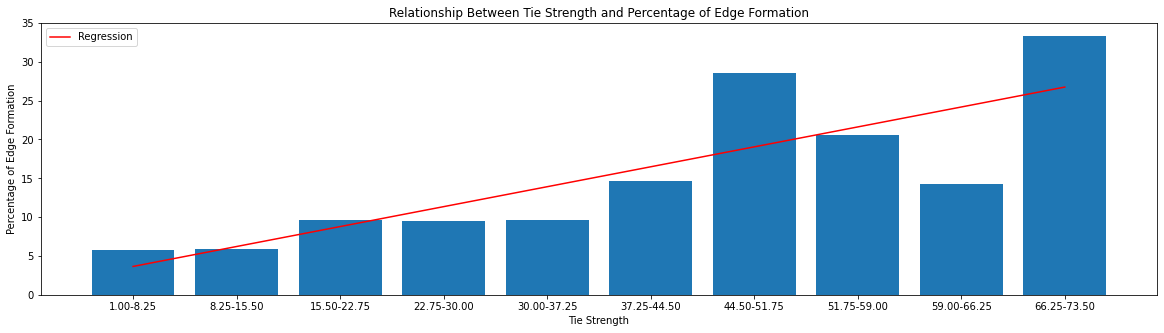

In [ ]:
tie_strength_to_connection_probability = plot_with_regression(range(n_intervals),
                     percentages,
                     title = "Relationship Between Tie Strength and Percentage of Edge Formation",
                     xlabel = "Tie Strength",
                     ylabel = "Percentage of Edge Formation",
                     line_label = "Regression",
                     tick_label = interval_names,
                     legend = True,
                     figsize=(20,5))

*Explanation: (Explanation for the proposed agorithm must be added here. The code above also needs comments in details for clarity and comprehension) 

# Predictive Power of the Number of Open Triades                                     <a id="chapter6"></a>

Find a regression model to evaluate whether the number of open triades influences the probability that a new collaboration is formed between 1995 and 2015. For example, node A and C do not have an edge, but could be connected by B (one open triad), A and D (two open triades) or even A, D and E (three open triades) and so forth. You have to draw a graph (with axis's lables and units) to illustrate your answer.

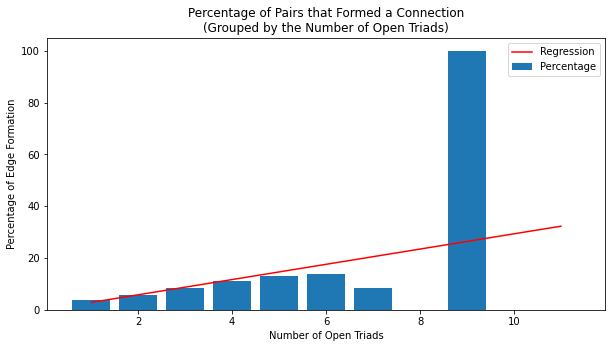

In [ ]:
# BEGIN SOLUTION
n_open_triads_total     = {}
n_open_triads_connected = {}
for pair in pairs:
    n_open_triads = len(pair.triangles)
    
    if n_open_triads not in n_open_triads_total:
        n_open_triads_total[n_open_triads] = 0
        n_open_triads_connected[n_open_triads] = 0

    n_open_triads_total[n_open_triads] += 1
    
    if pair.triangles[0].becomes_connected:
        n_open_triads_connected[n_open_triads] += 1   

keys = list(n_open_triads_total.keys())
ratios = [n_open_triads_connected[key]/n_open_triads_total[key]*100 for key in keys]

n_open_triads_to_connection_probability = plot_with_regression(keys, ratios,
                     title = "Percentage of Pairs that Formed a Connection\n(Grouped by the Number of Open Triads)",
                     xlabel = "Number of Open Triads",
                     ylabel = "Percentage of Edge Formation",
                     bar_label = "Percentage",
                     line_label = "Regression",
                     legend=True,
                     figsize=(10,5))
# END SOLUTION

*Explanation: (Explanation for the proposed agorithm must be added here. The code above also needs comments in details for clarity and comprehension) 

# Ranking Friends of Friends                                     <a id="chapter7"></a>

In this exercise you should apply your knowlege gained from the two previous exercises, but not limted to, to answer a common problem in todays social media platforms: given a person, an employee in our case, generate a ranked list of his friends of friends that are likely to become his friends. At the end of the following cell, we provide a code snippet that calculates the precision of your algorithm in predicting future ties in the top-10. Note that other knowledge you gained in the lectures also can be used to solve this problem.

In [ ]:
# employees to test
nodes = ['943855', '587677', '905252', '839906', '554748', '220387', '456096', '136755', '652488', '617192', '154879', '860536', '127930', '266261', '925761', '334823', '879631', '922044', '485657', '347203']
# dictionary mapping an employee to a list of employees with whom he/she collaborated in 2015 and which belonged
# to his friends of friends in 1995. 
result = {'879631': ['587677', '265264', '925761', '860536', '725186', '721127', '142327', '23872', '943855'], '127930': ['26850', '935705', '136755', '659445', '805057', '293364', '681672', '565759', '868762', '596394'], '154879': ['691913', '817338', '659445', '169325', '542646', '644335', '293364', '165240', '485657', '905252', '408618'], '587677': ['879631', '725186', '785747', '70007', '561122', '136755', '721127', '142327', '72828', '334823', '839906', '433369', '943855'], '266261': ['265264', '208388', '70007', '495819', '725186', '839906', '136755', '721127', '142327', '408600'], '860536': ['811970', '879631', '456096', '839906', '396817', '136755', '653075', '72828', '596215', '346572', '922044'], '839906': ['587677', '308351', '860536', '378229', '240448', '379649', '334823', '201753', '565759', '943855', '174262', '922044', '266261'], '347203': ['265464', '578175', '136755', '596215', '220387', '906277', '897180', '652488'], '617192': ['793831', '254964', '522310', '932010', '528813', '922964', '485657', '58492', '694245', '166980', '905252'], '136755': ['811970', '127930', '587677', '266261', '815411', '422460', '860536', '347203', '943855', '691913', '174262', '922044'], '925761': ['879631', '725186', '456096', '70007', '561122', '136803', '596215', '334823', '905252', '943855'], '554748': ['23872', '916957', '659445', '169325', '644335', '293364', '220387', '433369', '943855', '174262', '922044', '652488'], '334823': ['587677', '725186', '785747', '839906', '721127', '142327', '72828', '925761', '943855', '867536'], '220387': ['450166', '571150', '565465', '901612', '554748', '18282', '883925', '347203', '9418', '943855', '265464', '652488'], '485657': ['811970', '154879', '617192', '702341', '41963', '661899', '293364', '668817', '218489'], '905252': ['23872', '742360', '561250', '523695', '222137', '617192', '564846', '925761', '661899', '571150', '154879', '691913', '392536'], '943855': ['265264', '60541', '220387', '14499', '783415', '679997', '811970', '785747', '961828', '587677', '925761', '905502', '561122', '136755', '41963', '554748', '879631', '642974', '725186', '676753', '839906', '213482', '396817', '721127', '576951', '334823', '978812'], '456096': ['206983', '925761', '706765', '860536', '565708', '296067', '902949', '549825', '201753', '961828', '240448', '922044'], '922044': ['456096', '308351', '860536', '839906', '136755', '554748', '433369', '999230', '240448'], '652488': ['602959', '60541', '846007', '143158', '347203', '422460', '14499', '554748', '220387', '265464', '9418']}

def fof(G,n):
    '''
    returns the friends of friends of Node n in Graph G
    '''
    res = set()
    for n1 in G[n]:
        res = res | set(G[n1])
    res = res - set(G[n])
    return res

# BEGIN SOLUTION
# END SOLUTION

def score(n, f):
    '''
    calculates a score by which potential friends should be sorted
    '''
    s = 0
    # BEGIN SOLUTION
    # END SOLUTION
    return s

# Check 
topn = 10

for n in nodes:
    # get all friends of friends and their score
    fofG1995 = fof(G1995, n)
    l = [(f,score(n,f)) for f in fofG1995 ]
    # sort descending by score
    l.sort(key=lambda x: -x[1])
    # count number of correct results
    found = 0
    for x,z in l[:topn]:
        if x in result[n]:
            found += 1            
    print(n, found / float(topn))

*Explanation: (Explanation for the proposed agorithm must be added here. The code above also needs comments in details for clarity and comprehension)